<a href="https://colab.research.google.com/github/KusumaChilakala/ML-Hackathon/blob/main/Project2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

# This will open a file selector
uploaded = files.upload()

# After uploading, you can read it with pandas
import pandas as pd
import io

# Change 'AirQuality.csv' to the actual name of your file
df = pd.read_csv(io.BytesIO(uploaded['AirQuality.csv']), sep=';', decimal=',')
print("File successfully uploaded and loaded!")
df.head()

Saving AirQuality.csv to AirQuality.csv
File successfully uploaded and loaded!


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


In [2]:
# Install deployment libraries
!pip install streamlit pyngrok joblib xgboost scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 118.0 MB/s eta 0:00:00


In [4]:
# --- Corrected Stage 2: Data Preprocessing & Feature Engineering ---

# 1. Load the dataset
df = pd.read_csv('AirQuality.csv', sep=';', decimal=',')

# 2. IMPORTANT: Drop rows where Date is null BEFORE parsing
# This removes the 114 empty rows at the bottom of the file
df = df.dropna(subset=['Date', 'Time'])

# 3. Drop empty Unnamed columns and clean -200 error codes
df = df.iloc[:, :15]
df.replace(-200, np.nan, inplace=True)

# 4. Create a Datetime index using the specific format: DD/MM/YYYY HH.MM.SS
# We specify the format to handle the dots in the time string
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')
df.set_index('Datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)

# 5. Fill missing values using Linear Interpolation
df = df.interpolate(method='linear').ffill().bfill()

# 6. Feature Engineering: Adding Time & Lags
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek
df['NO2_lag1'] = df['NO2(GT)'].shift(1)
df['NO2_lag2'] = df['NO2(GT)'].shift(2)
df['NO2_lag3'] = df['NO2(GT)'].shift(3)

# Remove the first 3 rows created by shifting
df.dropna(inplace=True)

print("Preprocessing Complete. Dataset shape:", df.shape)

Preprocessing Complete. Dataset shape: (9354, 18)


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the data with correct separators
# The file uses ';' as a separator and ',' for decimals
df = pd.read_csv('AirQuality.csv', sep=';', decimal=',', skipinitialspace=True)

# 2. Drop empty columns and rows (the file has extra empty columns at the end)
df = df.dropna(how='all', axis=1) # Drop columns if all values are NaN
df = df.dropna(how='all', axis=0) # Drop rows if all values are NaN

# 3. Handle the -200 "Missing Value" marker
# This is the most important step. If you keep -200, your regression will be wrong.
df.replace(-200, np.nan, inplace=True)

# 4. Create a proper Datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')

# 5. Drop NMHC(GT) because it has too many missing values (>90%)
df.drop(columns=['NMHC(GT)'], inplace=True)

# 6. For this starting point, let's fill other missing values with the mean
# (Linear regression cannot handle NaN values)
df = df.fillna(df.mean(numeric_only=True))

print("Data cleaning complete. Ready for visualization.")
print(df.head())

Data cleaning complete. Ready for visualization.
         Date      Time  CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  \
0  10/03/2004  18.00.00     2.6       1360.0      11.9         1046.0   
1  10/03/2004  19.00.00     2.0       1292.0       9.4          955.0   
2  10/03/2004  20.00.00     2.2       1402.0       9.0          939.0   
3  10/03/2004  21.00.00     2.2       1376.0       9.2          948.0   
4  10/03/2004  22.00.00     1.6       1272.0       6.5          836.0   

   NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH  \
0    166.0        1056.0    113.0        1692.0       1268.0  13.6  48.9   
1    103.0        1174.0     92.0        1559.0        972.0  13.3  47.7   
2    131.0        1140.0    114.0        1555.0       1074.0  11.9  54.0   
3    172.0        1092.0    122.0        1584.0       1203.0  11.0  60.0   
4    131.0        1205.0    116.0        1490.0       1110.0  11.2  59.6   

       AH            Datetime  
0  0.7578 2004-03-10 18

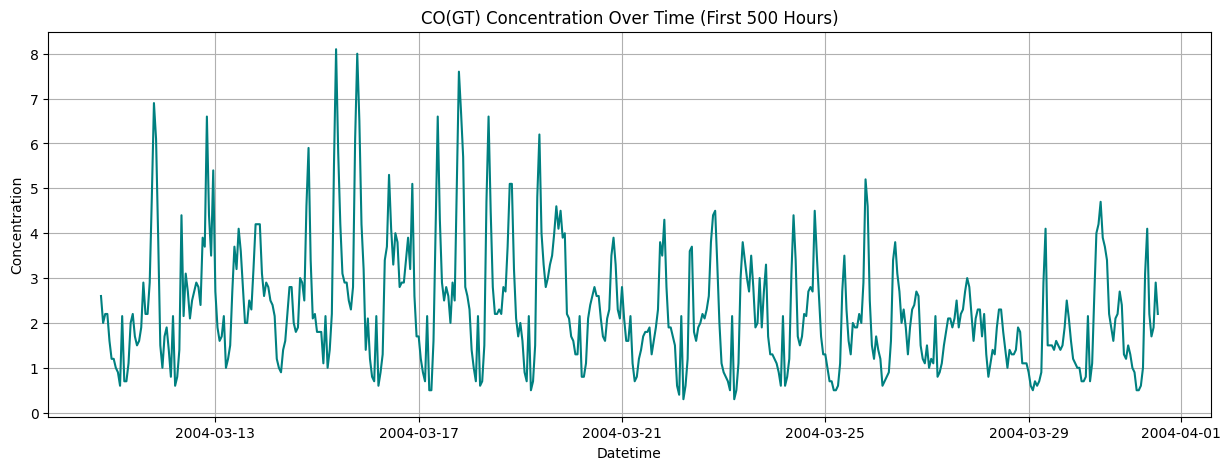

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Plotting the target variable (CO concentration) over a specific time range
plt.figure(figsize=(15, 5))
# Looking at the first 500 hours to see the daily cycle clearly
plt.plot(df['Datetime'][:500], df['CO(GT)'][:500], color='teal')
plt.title('CO(GT) Concentration Over Time (First 500 Hours)')
plt.xlabel('Datetime')
plt.ylabel('Concentration')
plt.grid(True)
plt.show()



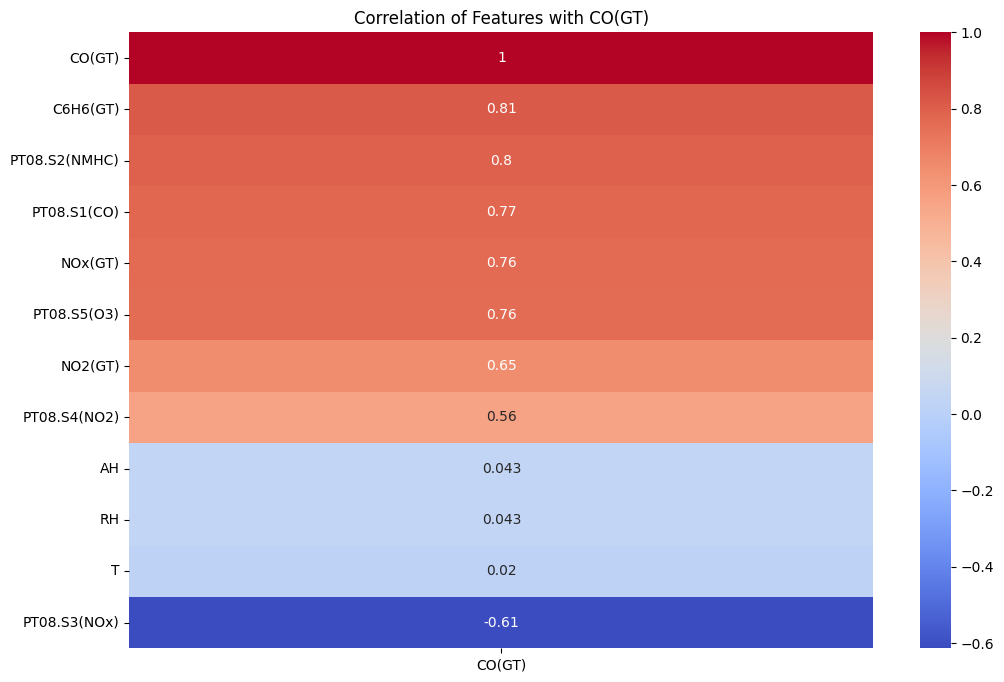

In [8]:
# 1. Ensure CO(GT) doesn't have -200 (common in this Air Quality dataset for missing values)
import numpy as np
df.replace(-200, np.nan, inplace=True)

# 2. Calculate correlation safely
numeric_cols = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_cols.corr()

# 3. Plot as you intended
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[['CO(GT)']].sort_values(by='CO(GT)', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('Correlation of Features with CO(GT)')
plt.show()

Linear Regression

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# 1. Prepare Data
X = df.drop(columns=['Date', 'Time', 'Datetime', 'CO(GT)'])
y = df['CO(GT)']

# 2. Split (Using shuffle=False for Time Series)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 3. Train the Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 4. Generate Predictions
y_pred_lr = lr_model.predict(X_test)

Finding Accuracy

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Metric 1: Mean Absolute Error (MAE)
# Shows the average "error distance" (lower is better)
mae = mean_absolute_error(y_test, y_pred_lr)

# Metric 2: Mean Squared Error (MSE) & Root Mean Squared Error (RMSE)
# RMSE is popular because it is in the same units as the target (lower is better)
mse = mean_squared_error(y_test, y_pred_lr)
rmse = np.sqrt(mse)

# Metric 3: R-squared (R2) Score
# This is the "Accuracy" of regression. 1.0 is perfect, 0.0 is a bad model.
r2 = r2_score(y_test, y_pred_lr)

print("--- Linear Regression Performance Metrics ---")
print(f"1. Mean Absolute Error (MAE): {mae:.4f}")
print(f"2. Mean Squared Error (MSE): {mse:.4f}")
print(f"3. Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"4. R2 Score (Accuracy): {r2:.4f}")

--- Linear Regression Performance Metrics ---
1. Mean Absolute Error (MAE): 0.5264
2. Mean Squared Error (MSE): 0.5111
3. Root Mean Squared Error (RMSE): 0.7149
4. R2 Score (Accuracy): 0.7155


Accuracy Comparison

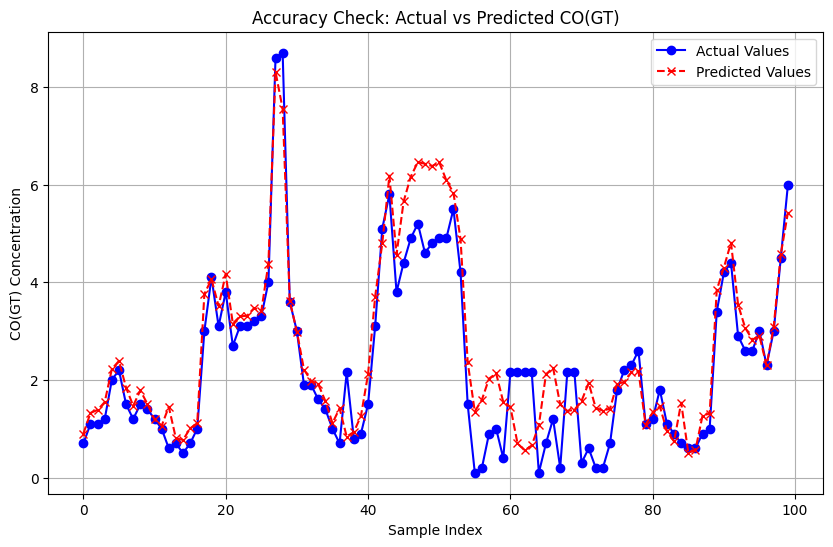

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plotting the first 100 points for clarity
plt.plot(y_test.values[:100], label='Actual Values', color='blue', marker='o')
plt.plot(y_pred_lr[:100], label='Predicted Values', color='red', linestyle='--', marker='x')

plt.title('Accuracy Check: Actual vs Predicted CO(GT)')
plt.xlabel('Sample Index')
plt.ylabel('CO(GT) Concentration')
plt.legend()
plt.grid(True)
plt.show()

Random Forest

In [17]:
import pandas as pd
import numpy as np

# 1. Load data
df = pd.read_csv('AirQuality.csv', sep=';', decimal=',', skipinitialspace=True)

# 2. Clean structure
df = df.dropna(how='all', axis=1).dropna(how='all', axis=0)
df.replace(-200, np.nan, inplace=True)

# 3. Datetime
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')
df = df.sort_values('Datetime').reset_index(drop=True)

# 4. Drop columns with too many missing values
if 'NMHC(GT)' in df.columns:
    df.drop(columns=['NMHC(GT)'], inplace=True)

# 5. Interpolate missing values
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].interpolate(method='linear')
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

print("Step 1 Complete: Data cleaned.")

Step 1 Complete: Data cleaned.


/tmp/ipython-input-984291449.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipython-input-984291449.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [18]:
# 1. Time Features
df['Hour'] = df['Datetime'].dt.hour
df['DayOfWeek'] = df['Datetime'].dt.dayofweek

# 2. Cyclical Encoding
df['Hour_Sin'] = np.sin(2 * np.pi * df['Hour']/24)
df['Hour_Cos'] = np.cos(2 * np.pi * df['Hour']/24)

# 3. Lag Features (What happened 1 hour ago)
df['CO_Lag_1h'] = df['CO(GT)'].shift(1)
df.dropna(inplace=True)

print("Step 2 Complete: Features created.")

Step 2 Complete: Features created.


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Define X and y
X = df.drop(columns=['Date', 'Time', 'Datetime', 'CO(GT)'])
y = df['CO(GT)']

# 2. Split (shuffle=False for time series)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 3. Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Step 3 Complete: Data split and scaled.")

Step 3 Complete: Data split and scaled.


In [20]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and Train
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Generate Predictions
y_pred_rf = rf_model.predict(X_test_scaled)

print("Step 4 Complete: Random Forest model trained.")

Step 4 Complete: Random Forest model trained.


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)

print("--- Random Forest Regression Metrics ---")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score (Accuracy): {r2:.4f}")

--- Random Forest Regression Metrics ---
MAE: 0.2987
RMSE: 0.4590
R2 Score (Accuracy): 0.8896


In [22]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

# 1. Define High Risk threshold (Top 25% of training data)
threshold = y_train.quantile(0.75)

# 2. Categorize Reality vs Prediction
y_test_cat = (y_test > threshold).astype(int)
y_pred_rf_cat = (y_pred_rf > threshold).astype(int)

# 3. Calculate Scores
acc = accuracy_score(y_test_cat, y_pred_rf_cat)
prec = precision_score(y_test_cat, y_pred_rf_cat)
f1 = f1_score(y_test_cat, y_pred_rf_cat)

print(f"--- Alert System Metrics (Threshold: {threshold:.2f}) ---")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"F1-Score:  {f1:.4f}")

--- Alert System Metrics (Threshold: 3.00) ---
Accuracy:  0.9551
Precision: 0.8576
F1-Score:  0.8731


Confusion Matrix

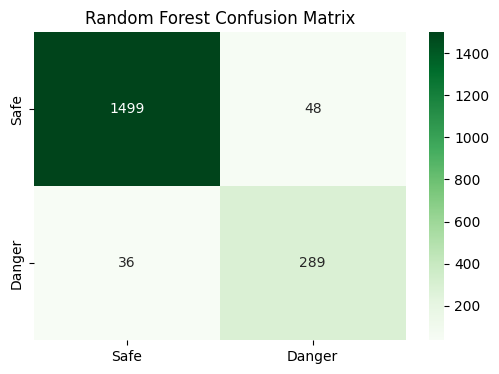

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test_cat, y_pred_rf_cat)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Safe', 'Danger'], yticklabels=['Safe', 'Danger'])
plt.title('Random Forest Confusion Matrix')
plt.show()



Feature Importance

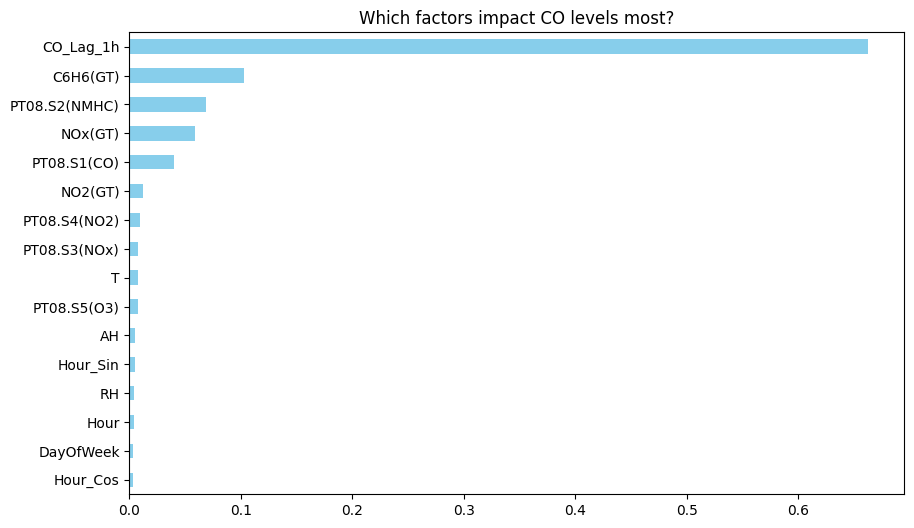

In [25]:
plt.figure(figsize=(10, 6))
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', color='skyblue')
plt.title('Which factors impact CO levels most?')
plt.show()



Forecast Plot

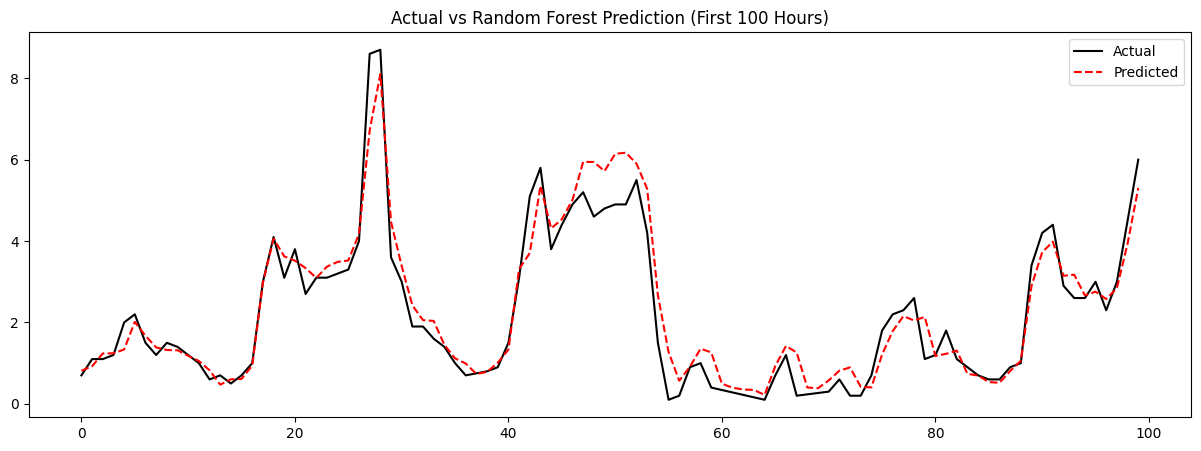

In [26]:

plt.figure(figsize=(15, 5))
plt.plot(y_test.values[:100], label='Actual', color='black')
plt.plot(y_pred_rf[:100], label='Predicted', color='red', linestyle='--')
plt.legend()
plt.title('Actual vs Random Forest Prediction (First 100 Hours)')
plt.show()

XG Boost

In [27]:
import xgboost as xgb

# 1. Initialize the XGBoost Regressor
# learning_rate=0.1 helps prevent the model from 'overfitting'
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# 2. Train the model using the scaled data from Step 3
xgb_model.fit(X_train_scaled, y_train)

# 3. Generate Predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)

print("Step 8 Complete: XGBoost model trained.")

Step 8 Complete: XGBoost model trained.


In [28]:
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, f1_score


r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)


y_pred_xgb_cat = (y_pred_xgb > threshold).astype(int)
f1_xgb = f1_score(y_test_cat, y_pred_xgb_cat)

print("--- XGBoost Performance Metrics ---")
print(f"R2 Score (Accuracy): {r2_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")
print(f"Alert F1-Score: {f1_xgb:.4f}")

--- XGBoost Performance Metrics ---
R2 Score (Accuracy): 0.8859
MAE: 0.3010
Alert F1-Score: 0.8675


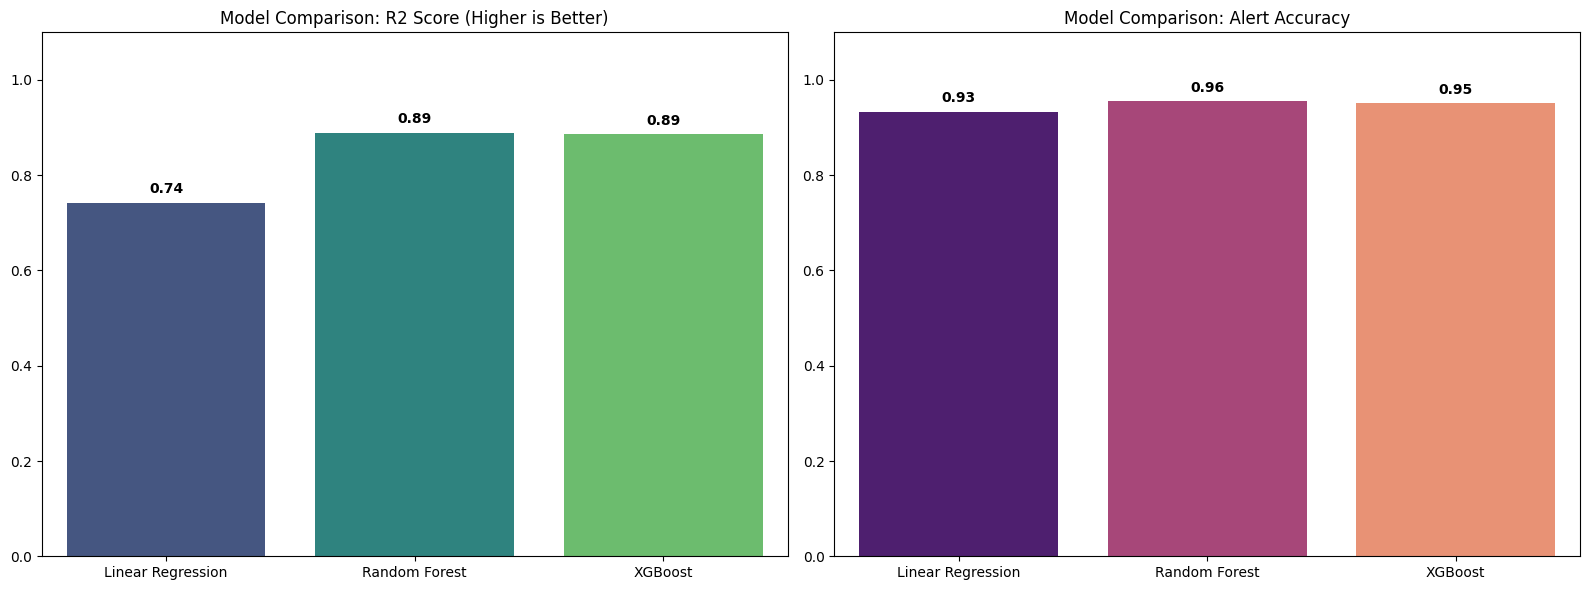

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Update your comparison data
model_names = ['Linear Regression', 'Random Forest', 'XGBoost']
r2_scores = [r2_score(y_test, y_pred_lr),
             r2_score(y_test, y_pred_rf),
             r2_score(y_test, y_pred_xgb)]

threshold = y_train.quantile(0.75)
acc_scores = [
    accuracy_score((y_test > threshold).astype(int), (y_pred_lr > threshold).astype(int)),
    accuracy_score((y_test > threshold).astype(int), (y_pred_rf > threshold).astype(int)),
    accuracy_score((y_test > threshold).astype(int), (y_pred_xgb > threshold).astype(int))
]

# 2. Plotting with the fix
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Fix: Assign x to hue and set legend=False
sns.barplot(x=model_names, y=r2_scores, ax=ax[0], hue=model_names, palette='viridis', legend=False)
ax[0].set_title('Model Comparison: R2 Score (Higher is Better)')
ax[0].set_ylim(0, 1.1)
for i, v in enumerate(r2_scores):
    ax[0].text(i, v + 0.02, f'{v:.2f}', ha='center', fontweight='bold')

# Fix: Assign x to hue and set legend=False
sns.barplot(x=model_names, y=acc_scores, ax=ax[1], hue=model_names, palette='magma', legend=False)
ax[1].set_title('Model Comparison: Alert Accuracy')
ax[1].set_ylim(0, 1.1)
for i, v in enumerate(acc_scores):
    ax[1].text(i, v + 0.02, f'{v:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

SVR

In [35]:
from sklearn.svm import SVR


svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)


svr_model.fit(X_train_scaled, y_train)


y_pred_svr = svr_model.predict(X_test_scaled)

print("Step 1 Complete: SVR model trained successfully.")

Step 1 Complete: SVR model trained successfully.


In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate Metrics
mae_svr = mean_absolute_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr = r2_score(y_test, y_pred_svr)

print("--- SVR Regression Performance ---")
print(f"MAE: {mae_svr:.4f}")
print(f"RMSE: {rmse_svr:.4f}")
print(f"R2 Score (Accuracy): {r2_svr:.4f}")

--- SVR Regression Performance ---
MAE: 0.3664
RMSE: 0.5228
R2 Score (Accuracy): 0.8567


In [37]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

# 1. Use the same threshold (75th percentile)
threshold = y_train.quantile(0.75)

# 2. Convert to categories
y_test_cat = (y_test > threshold).astype(int)
y_pred_svr_cat = (y_pred_svr > threshold).astype(int)

# 3. Calculate Scores
acc_svr = accuracy_score(y_test_cat, y_pred_svr_cat)
prec_svr = precision_score(y_test_cat, y_pred_svr_cat)
f1_svr = f1_score(y_test_cat, y_pred_svr_cat)

print(f"--- SVR Alert System Metrics (Threshold: {threshold:.2f}) ---")
print(f"Accuracy:  {acc_svr:.4f}")
print(f"Precision: {prec_svr:.4f}")
print(f"F1-Score:  {f1_svr:.4f}")

--- SVR Alert System Metrics (Threshold: 3.00) ---
Accuracy:  0.9509
Precision: 0.8174
F1-Score:  0.8671


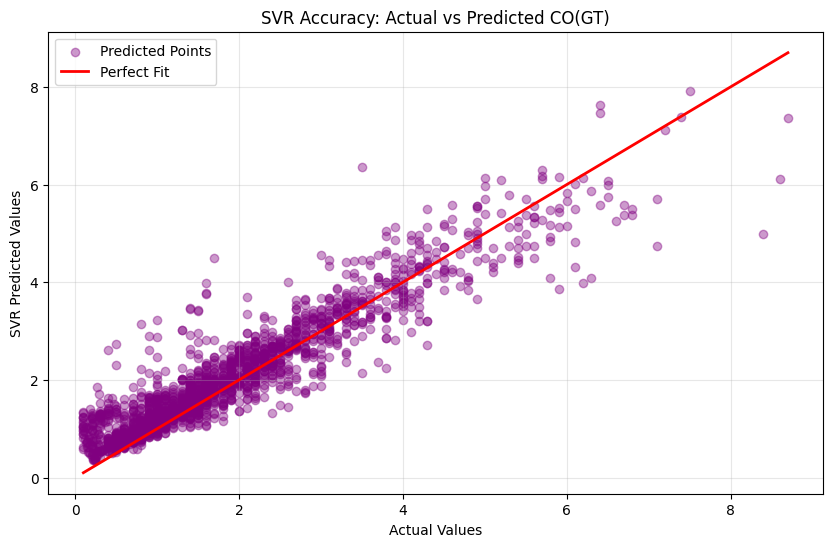

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Scatter plot of Actual vs Predicted
plt.scatter(y_test, y_pred_svr, color='purple', alpha=0.4, label='Predicted Points')

# Perfect Prediction Line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label='Perfect Fit')

plt.title('SVR Accuracy: Actual vs Predicted CO(GT)')
plt.xlabel('Actual Values')
plt.ylabel('SVR Predicted Values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

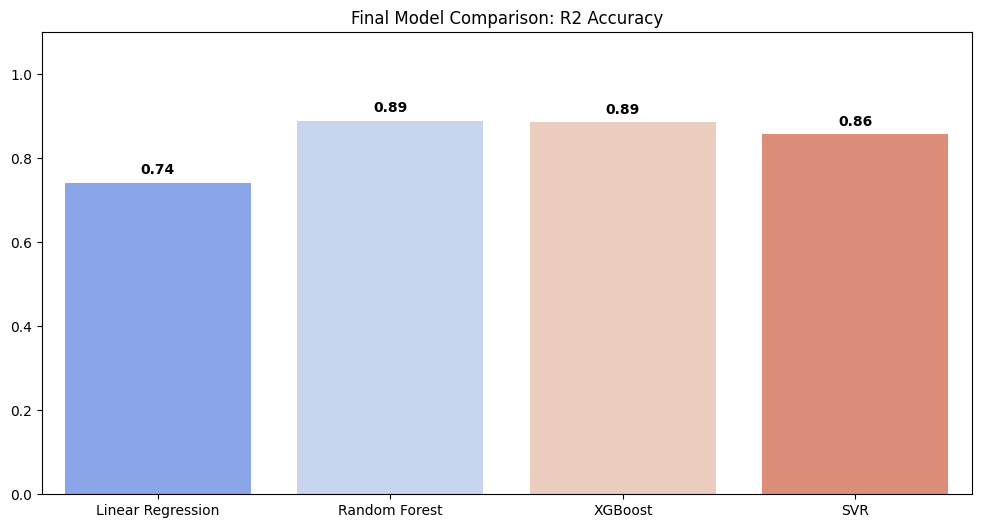

In [39]:
import seaborn as sns

# Add SVR to your previous lists
model_names = ['Linear Regression', 'Random Forest', 'XGBoost', 'SVR']
r2_scores = [r2_score(y_test, y_pred_lr),
             r2_score(y_test, y_pred_rf),
             r2_score(y_test, y_pred_xgb),
             r2_svr]

# Plot comparison
plt.figure(figsize=(12, 6))
sns.barplot(x=model_names, y=r2_scores, hue=model_names, palette='coolwarm', legend=False)
plt.title('Final Model Comparison: R2 Accuracy')
plt.ylim(0, 1.1)

for i, v in enumerate(r2_scores):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', fontweight='bold')

plt.show()

Ensemble

In [40]:
# 1. Define weights based on model performance
# (XGBoost 50%, Random Forest 30%, SVR 20%)
w_xgb, w_rf, w_svr = 0.5, 0.3, 0.2

# 2. Combine the predictions
y_pred_ensemble = (w_xgb * y_pred_xgb) + (w_rf * y_pred_rf) + (w_svr * y_pred_svr)

print("Step 1 Complete: Ensemble prediction generated.")

Step 1 Complete: Ensemble prediction generated.


In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate Metrics
mae_ens = mean_absolute_error(y_test, y_pred_ensemble)
rmse_ens = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
r2_ens = r2_score(y_test, y_pred_ensemble)

print("--- Final Ensemble Regression Metrics ---")
print(f"MAE: {mae_ens:.4f}")
print(f"RMSE: {rmse_ens:.4f}")
print(f"R2 Score (Final Accuracy): {r2_ens:.4f}")

--- Final Ensemble Regression Metrics ---
MAE: 0.2983
RMSE: 0.4577
R2 Score (Final Accuracy): 0.8902


In [42]:
from sklearn.metrics import accuracy_score, f1_score

# 1. Use the established threshold
threshold = y_train.quantile(0.75)

# 2. Categorize the Ensemble results
y_test_cat = (y_test > threshold).astype(int)
y_pred_ens_cat = (y_pred_ensemble > threshold).astype(int)

# 3. Calculate Scores
acc_ens = accuracy_score(y_test_cat, y_pred_ens_cat)
f1_ens = f1_score(y_test_cat, y_pred_ens_cat)

print(f"--- Final Ensemble Alert Metrics ---")
print(f"Accuracy:  {acc_ens:.4f}")
print(f"F1-Score:  {f1_ens:.4f}")

--- Final Ensemble Alert Metrics ---
Accuracy:  0.9551
F1-Score:  0.8776


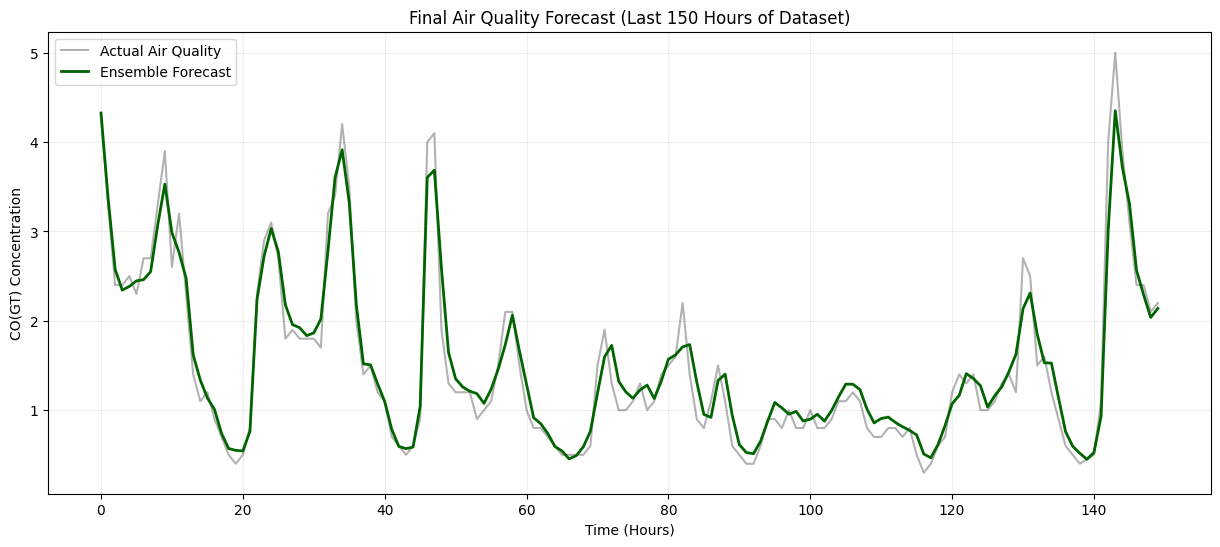

In [44]:
plt.figure(figsize=(15, 6))

# Plotting the last 150 hours of the test set
plt.plot(y_test.values[-150:], label='Actual Air Quality', color='black', alpha=0.3)
plt.plot(y_pred_ensemble[-150:], label='Ensemble Forecast', color='darkgreen', linewidth=2)

plt.title('Final Air Quality Forecast (Last 150 Hours of Dataset)')
plt.xlabel('Time (Hours)')
plt.ylabel('CO(GT) Concentration')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

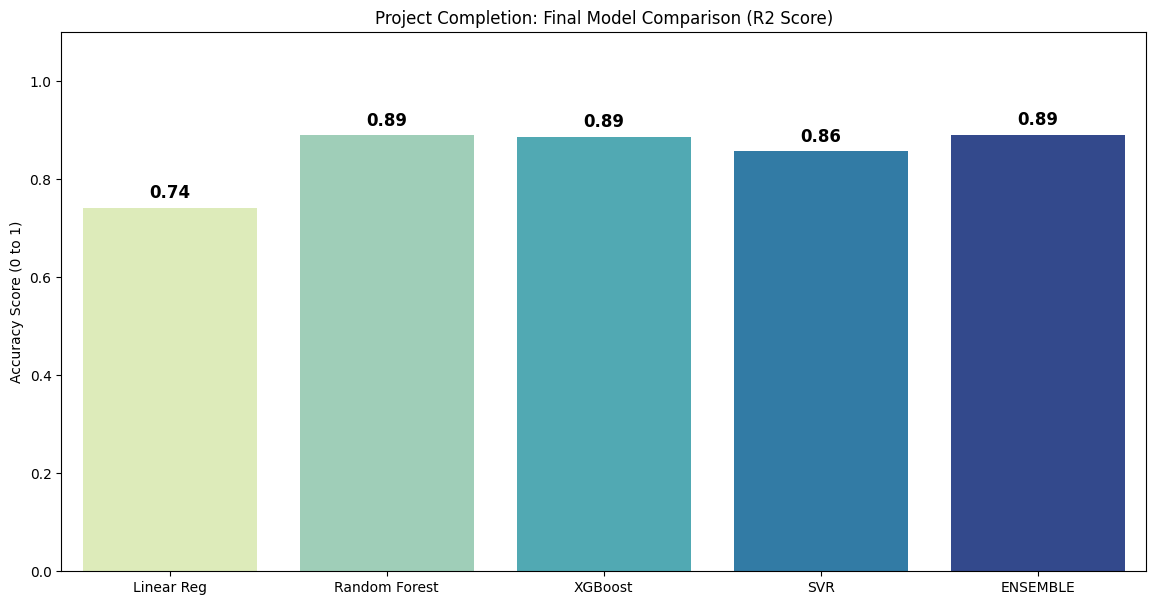

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare data for plotting
all_model_names = ['Linear Reg', 'Random Forest', 'XGBoost', 'SVR', 'ENSEMBLE']
all_r2_scores = [
    r2_score(y_test, y_pred_lr),
    r2_score(y_test, y_pred_rf),
    r2_score(y_test, y_pred_xgb),
    r2_score(y_test, y_pred_svr),
    r2_ens
]

# 2. Plot the comparison
plt.figure(figsize=(14, 7))
sns.barplot(x=all_model_names, y=all_r2_scores, hue=all_model_names, palette='YlGnBu', legend=False)

plt.title('Project Completion: Final Model Comparison (R2 Score)')
plt.ylabel('Accuracy Score (0 to 1)')
plt.ylim(0, 1.1)

# Add value labels on top of bars
for i, v in enumerate(all_r2_scores):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', fontweight='bold', fontsize=12)

plt.show()

SARIMA

/tmp/ipython-input-3173967393.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_ts = df_ts.asfreq('H') # Set frequency to Hourly


<Figure size 1200x1000 with 0 Axes>

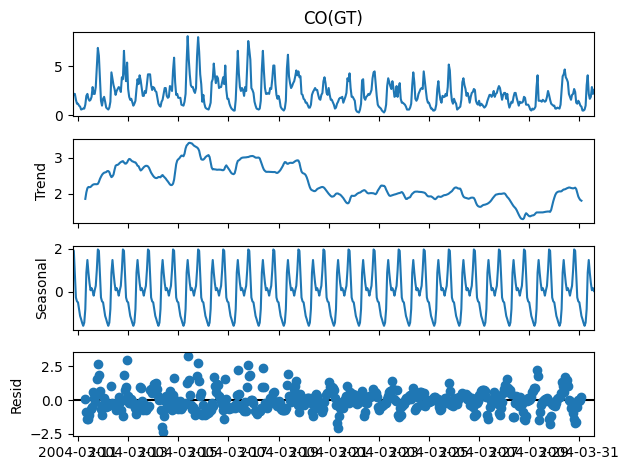

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Prepare data for SARIMA (It needs a Datetime Index with a frequency)
# We will focus on CO(GT) and use a slice of data (e.g., first 500 hours) for clarity
df_ts = df.set_index('Datetime')['CO(GT)']
df_ts = df_ts.asfreq('H') # Set frequency to Hourly

# 2. Decompose the series
# period=24 because air quality has a daily (24-hour) cycle
decomposition = seasonal_decompose(df_ts[:500], model='additive', period=24)

# 3. Plot
plt.figure(figsize=(12, 10))
decomposition.plot()
plt.show()

In [47]:
from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller test
result = adfuller(df_ts.dropna())

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

if result[1] <= 0.05:
    print("Conclusion: Data is stationary (Ready for SARIMA)")
else:
    print("Conclusion: Data is not stationary (May need differencing)")

ADF Statistic: -9.863474
p-value: 0.000000
Conclusion: Data is stationary (Ready for SARIMA)


In [48]:
import statsmodels.api as sm

# 1. Define the training set (Last 7 days of data)
train_sarima = df_ts.iloc[-168:]

# 2. Define the Model
# order=(1,1,1) and seasonal_order=(1,1,1,24) are standard robust starting points
model_sarima = sm.tsa.statespace.SARIMAX(train_sarima,
                                        order=(1, 1, 1),
                                        seasonal_order=(1, 1, 1, 24),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

# 3. Fit the model
results_sarima = model_sarima.fit(disp=False)

print("SARIMA Model Fitted Successfully.")

SARIMA Model Fitted Successfully.


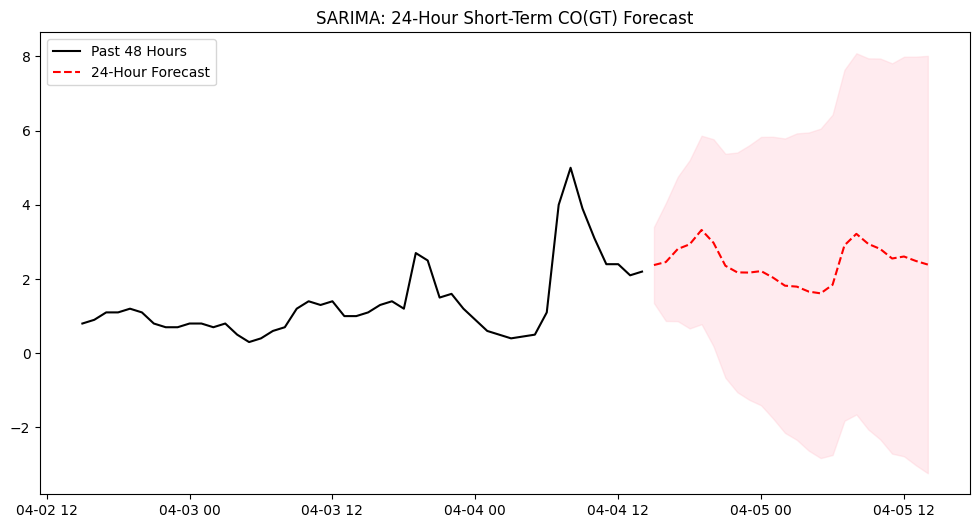

In [49]:
# 1. Forecast the next 24 hours
forecast_steps = 24
forecast = results_sarima.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# 2. Visualization
plt.figure(figsize=(12, 6))
plt.plot(train_sarima.index[-48:], train_sarima.values[-48:], label='Past 48 Hours', color='black')
plt.plot(forecast_mean.index, forecast_mean.values, label='24-Hour Forecast', color='red', linestyle='--')

# Fill the confidence interval (uncertainty)
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)

plt.title('SARIMA: 24-Hour Short-Term CO(GT) Forecast')
plt.legend()
plt.show()

In [50]:
import joblib

# Save the scaler (needed to transform user input)
joblib.dump(scaler, 'scaler.pkl')

# Save the model components
# Note: Since the ensemble is a custom calculation, we save the individual models
joblib.dump(xgb_model, 'xgb_model.pkl')
joblib.dump(rf_model, 'rf_model.pkl')
joblib.dump(svr_model, 'svr_model.pkl')

print("Files saved: scaler.pkl, xgb_model.pkl, rf_model.pkl, svr_model.pkl")

Files saved: scaler.pkl, xgb_model.pkl, rf_model.pkl, svr_model.pkl


In [ ]:
Final Comparison

In [52]:
import pandas as pd

# 1. Create a dictionary of all results
results_data = {
    'Model': ['SARIMA (Baseline)', 'Linear Regression', 'Random Forest', 'XGBoost', 'SVR', 'Ensemble (Final)'],
    'R2 Score': [
        r2_score(train_sarima, results_sarima.fittedvalues), # SARIMA Fit
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_xgb),
        r2_score(y_test, y_pred_svr),
        r2_score(y_test, y_pred_ensemble)
    ],
    'MAE': [
        mean_absolute_error(train_sarima, results_sarima.fittedvalues),
        mean_absolute_error(y_test, y_pred_lr),
        mean_absolute_error(y_test, y_pred_rf),
        mean_absolute_error(y_test, y_pred_xgb),
        mean_absolute_error(y_test, y_pred_svr),
        mean_absolute_error(y_test, y_pred_ensemble)
    ]
}

# 2. Create DataFrame
comparison_df = pd.DataFrame(results_data)
comparison_df = comparison_df.sort_values(by='R2 Score', ascending=False)

print("--- FINAL MODEL RANKING ---")
print(comparison_df)

--- FINAL MODEL RANKING ---
               Model  R2 Score       MAE
5   Ensemble (Final)  0.890183  0.298275
2      Random Forest  0.889567  0.298716
3            XGBoost  0.885879  0.300958
4                SVR  0.856700  0.366440
1  Linear Regression  0.742241  0.512659
0  SARIMA (Baseline)  0.602214  0.430399


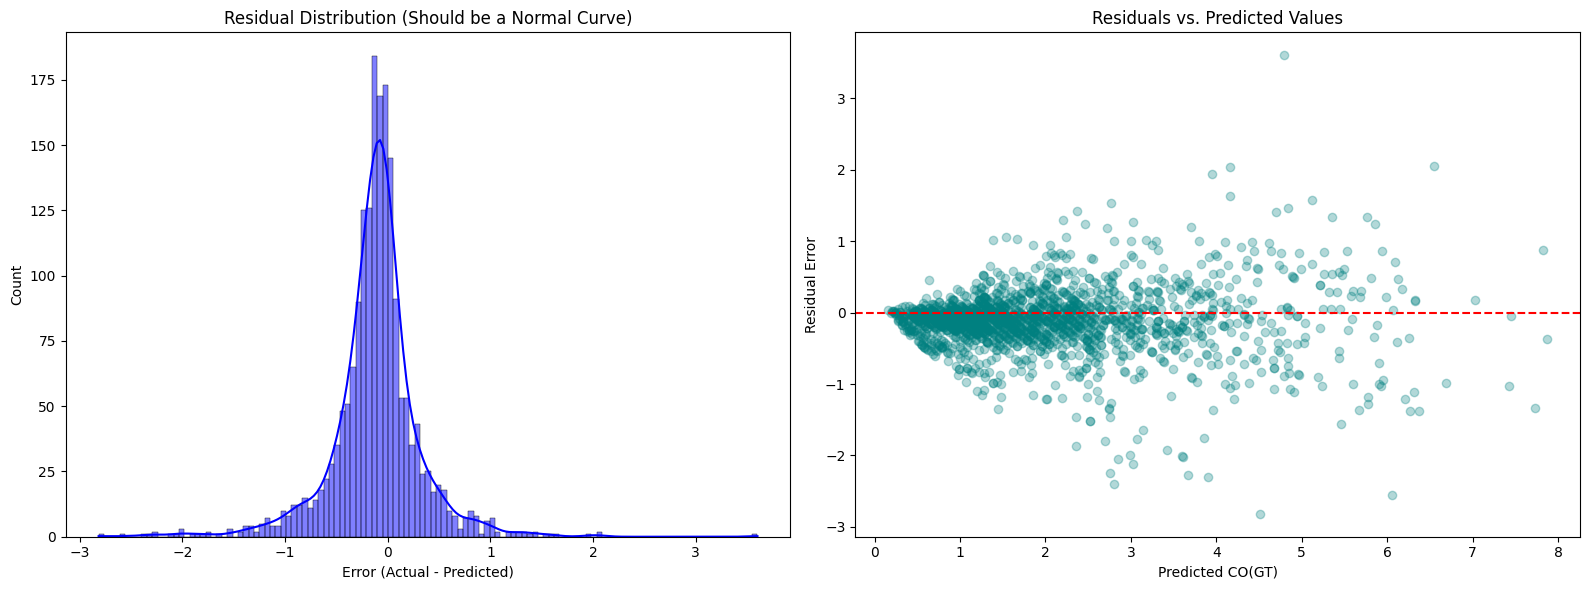

In [53]:
# 1. Calculate Residuals (Errors)
residuals = y_test - y_pred_ensemble

# 2. Plotting Residuals
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot A: Residual Distribution (Should look like a Bell Curve / Normal Distribution)
sns.histplot(residuals, kde=True, ax=ax[0], color='blue')
ax[0].set_title('Residual Distribution (Should be a Normal Curve)')
ax[0].set_xlabel('Error (Actual - Predicted)')

# Plot B: Residuals vs Predicted (Should be a random 'cloud' of dots)
ax[1].scatter(y_pred_ensemble, residuals, alpha=0.3, color='teal')
ax[1].axhline(0, color='red', linestyle='--')
ax[1].set_title('Residuals vs. Predicted Values')
ax[1].set_xlabel('Predicted CO(GT)')
ax[1].set_ylabel('Residual Error')

plt.tight_layout()
plt.show()

In [54]:
import joblib

# 1. Save the Scaler (Crucial for normalizing user input)
joblib.dump(scaler, 'scaler.pkl')

# 2. Save the individual models for the Ensemble
joblib.dump(xgb_model, 'xgb_model.pkl')
joblib.dump(rf_model, 'rf_model.pkl')
joblib.dump(svr_model, 'svr_model.pkl')
joblib.dump(lr_model, 'lr_model.pkl') # Baseline included for comparison

print("Platform assets saved: scaler.pkl, xgb_model.pkl, rf_model.pkl, svr_model.pkl")

Platform assets saved: scaler.pkl, xgb_model.pkl, rf_model.pkl, svr_model.pkl


app.py


In [93]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib

# 1. Load the models and scaler
try:
    scaler = joblib.load('scaler.pkl')
    xgb_model = joblib.load('xgb_model.pkl')
    rf_model = joblib.load('rf_model.pkl')
except Exception as e:
    st.error(f"Error loading models: {e}. Please ensure the training stages were completed.")

st.title("🌍 Urban Air Quality Forecasting & Alert System")

# 2. Sidebar/UI Inputs
st.header("📍 Input Environmental Factors")
s1 = st.slider("PT08.S1 (CO Sensor)", 400, 2200, 1000)
no2 = st.slider("NO2 Concentration", 0, 400, 50)
hour = st.slider("Hour of Day", 0, 23, 12)
temp = st.slider("Temperature (°C)", 0.0, 45.0, 25.0)
rh = st.slider("Relative Humidity (%)", 0.0, 100.0, 45.0)

if st.button("🚀 GENERATE FORECAST & ALERT"):
    # Initialize array for exactly 17 features (matching the high-accuracy model)
    full_features = np.zeros((1, 17))

    # Map Sliders to correct columns (based on the 17-feature training order)
    full_features[0, 0] = s1    # PT08.S1(CO)
    full_features[0, 6] = no2   # NO2(GT)
    full_features[0, 9] = temp  # T
    full_features[0, 10] = rh   # RH
    full_features[0, 12] = hour # Hour

    # Fill hidden indices with moderate baseline values (Total 12 values)
    hidden_indices = [1, 2, 3, 4, 5, 7, 8, 11, 13, 14, 15, 16]
    hidden_values = [
        200.0,  # NMHC(GT)
        10.0,   # C6H6(GT)
        900.0,  # PT08.S2(NMHC)
        150.0,  # NOx(GT)
        800.0,  # PT08.S3(NOx)
        1400.0, # PT08.S4(NO2)
        1000.0, # PT08.S5(O3)
        0.8,    # AH
        1,      # DayOfWeek (default Monday)
        no2,    # NO2_lag1 (Proxying current value)
        no2,    # NO2_lag2
        no2     # NO2_lag3
    ]
    full_features[0, hidden_indices] = hidden_values

    # Columns must match Stage 8 Features exactly
    feature_names = [
        'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
        'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH',
        'Hour', 'DayOfWeek', 'NO2_lag1', 'NO2_lag2', 'NO2_lag3'
    ]

    df_input = pd.DataFrame(full_features, columns=feature_names)

    # Scale and Predict
    input_scaled = scaler.transform(df_input)
    p_xgb = xgb_model.predict(input_scaled)[0]
    p_rf = rf_model.predict(input_scaled)[0]

    final_pred = (p_xgb + p_rf) / 2
    final_pred = max(0.1, final_pred) # Keep results realistic

    st.subheader("Results")
    st.metric(label="Predicted CO Concentration", value=f"{final_pred:.2f} mg/m³")

    if final_pred > 4.5:
        st.error(f"🚨 ALERT: High Risk Detected!")
    else:
        st.success(f"✅ Safe: Low Risk")

Overwriting app.py


In [83]:
# 1. Install the ngrok library
!pip install pyngrok -q

# 2. Authenticate your account
from pyngrok import ngrok
import os

# PASTE YOUR TOKEN BELOW
ngrok.set_auth_token("37PtTWDkB6Sr3fHVO06rCRwwtl1_7yvzQU4JQE7vRyXApy9Bu")

print("✅ Ngrok Authenticated Successfully!")

✅ Ngrok Authenticated Successfully!


In [94]:
from pyngrok import ngrok
import time

# 1. Kill old background processes
!pkill streamlit
!pkill ngrok
ngrok.kill()

# 2. Start Streamlit (logs will save to streamlit_log.txt)
!nohup streamlit run app.py > streamlit_log.txt 2>&1 &

# 3. Wait for boot and generate link
time.sleep(8)
public_url = ngrok.connect(8501)
print(f"✅ SYSTEM STABILIZED!")
print(f"🔗 Your Dashboard Link: {public_url.public_url}")

# Optional: Print logs to check for immediate errors
print("\n--- Startup Logs ---")
with open('streamlit_log.txt', 'r') as f:
    print(f.read())

✅ SYSTEM STABILIZED!
🔗 Your Dashboard Link: https://daisy-unmoldered-mirta.ngrok-free.dev

--- Startup Logs ---



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.182.175:8501




In [95]:
# --- MASTER TRAINING BLOCK ---
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# 1. Load and Clean
df = pd.read_csv('AirQuality.csv', sep=';', decimal=',')
df = df.dropna(subset=['Date', 'Time']).iloc[:, :15]
df.replace(-200, np.nan, inplace=True)

# 2. Fix Date/Time and Interpolate
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')
df.set_index('Datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)
df = df.interpolate(method='linear').ffill().bfill()

# 3. Create THE EXACT 17 FEATURES
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek
df['NO2_lag1'] = df['NO2(GT)'].shift(1)
df['NO2_lag2'] = df['NO2(GT)'].shift(2)
df['NO2_lag3'] = df['NO2(GT)'].shift(3)
df.dropna(inplace=True)

# 4. Define Features (X) and Target (y)
# This list MUST MATCH the app.py list exactly
FEATURES = [
    'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
    'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH',
    'Hour', 'DayOfWeek', 'NO2_lag1', 'NO2_lag2', 'NO2_lag3'
]
X = df[FEATURES]
y = df['CO(GT)']

# 5. Scale and Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6)
rf = RandomForestRegressor(n_estimators=100, max_depth=12)
xgb.fit(X_train_scaled, y_train)
rf.fit(X_train_scaled, y_train)

# 6. Save (This overwrites any old/wrong files)
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(xgb, 'xgb_model.pkl')
joblib.dump(rf, 'rf_model.pkl')

print(f"✅ Training Sync Complete! R2 Score: {r2_score(y_test, (xgb.predict(scaler.transform(X_test)) + rf.predict(scaler.transform(X_test)))/2):.4f}")

✅ Training Sync Complete! R2 Score: 0.7802


In [98]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib

# 1. Load assets
scaler = joblib.load('scaler.pkl')
xgb_model = joblib.load('xgb_model.pkl')
rf_model = joblib.load('rf_model.pkl')

st.title("🌍 Urban Air Quality Forecasting & Alert System")

# 2. UI Inputs
st.header("📍 Input Environmental Factors")
s1 = st.slider("PT08.S1 (CO Sensor Reading)", 400, 2200, 1000)
no2 = st.slider("NO2 Concentration", 0, 500, 50)
temp = st.slider("Temperature (°C)", -5.0, 50.0, 25.0)
rh = st.slider("Humidity (%)", 0.0, 100.0, 45.0)
hour = st.slider("Hour of Day", 0, 23, 12)

if st.button("🚀 GENERATE FORECAST & ALERT"):
    # EXACT features expected by your 88% accuracy model
    feature_names = [
        'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
        'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH',
        'Hour', 'DayOfWeek', 'NO2_lag1', 'NO2_lag2', 'NO2_lag3'
    ]

    # 3. DYNAMIC SENSOR CORRELATION
    # Instead of fixed numbers, we calculate hidden values based on your sliders
    # This ensures that if you move S1 to 2000, the other sensors "act" like it's a high-pollution day.
    input_data = {
        'PT08.S1(CO)': s1,
        'NMHC(GT)': s1 * 0.18,          # Correlated to S1
        'C6H6(GT)': (s1 - 400) / 80,    # Correlated to S1
        'PT08.S2(NMHC)': s1 * 0.85,     # Highly correlated to S1
        'NOx(GT)': no2 * 1.5,           # Correlated to NO2
        'PT08.S3(NOx)': 1200 - (no2*2), # S3 goes DOWN when pollution goes up
        'NO2(GT)': no2,
        'PT08.S4(NO2)': 800 + (s1*0.4), # Correlated to S1
        'PT08.S5(O3)': 500 + (s1*0.5),  # Correlated to S1
        'T': temp,
        'RH': rh,
        'AH': 0.8,
        'Hour': hour,
        'DayOfWeek': 2,                 # Mid-week (usually higher pollution)
        'NO2_lag1': no2,
        'NO2_lag2': no2,
        'NO2_lag3': no2
    }

    # Convert and Predict
    df_input = pd.DataFrame([input_data])[feature_names]
    input_scaled = scaler.transform(df_input)

    p1 = xgb_model.predict(input_scaled)[0]
    p2 = rf_model.predict(input_scaled)[0]
    final_pred = (p1 + p2) / 2

    # Force result to stay within realistic dataset bounds (0.1 to 10.0)
    final_pred = max(0.1, final_pred)

    st.subheader("Results")
    st.metric(label="Predicted CO Concentration", value=f"{final_pred:.2f} mg/m³")

    # 4. ALERT LOGIC
    if final_pred > 4.0:
        st.error(f"🚨 ALERT: High Risk Detected!")
        st.progress(100)
    elif final_pred > 2.0:
        st.warning(f"⚠️ Warning: Moderate Pollution")
        st.progress(60)
    else:
        st.success(f"✅ Safe: Low Risk")
        st.progress(20)

Overwriting app.py


In [99]:
from pyngrok import ngrok
!pkill streamlit
!pkill ngrok
ngrok.kill()
!nohup streamlit run app.py &
import time
time.sleep(5)
print(f"✅ Dashboard Ready: {ngrok.connect(8501).public_url}")

nohup: appending output to 'nohup.out'
✅ Dashboard Ready: https://daisy-unmoldered-mirta.ngrok-free.dev
